# Lab 03-3

Modeling Canopy Photosynthesis

<div class="alert alert-warning">
If equations or tables are not displayed properly, please go to the top menu and select View - Activate Command Palette, then search for and execute the "Trust Notebook" command.
</div>

<div class="alert alert-info">
Some parts of the code are left empty like #= .. =#, please fill in those parts during the practice session.
</div>

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

### Ex 1

Using Cropbox, you will evaluate three different systems for modeling instantaneous canopy photosynthesis ($A_{g,\mathrm{can}}$) based on the Appendix (section A.2) of Goudriaan and van Laar (1994) and also Goudriaan (1986):
- Build system based on 1) analytical solution, 2) Gaussian 3 point integration method, and 3) Rectangular integration (Eulerian) method over total LAI ($L$) with an increment ($dl$) = 1.0 and 0.1.
- Reproduce the results shown in  Appendix (section A.2) of Goudriaan and van Laar(1994) for the same conditions
- Plot *gross* canopy photosynthesis ($A_{g,\mathrm{can}}$) to compare the three approaches in response to LAI ranging from 0 to 10
- Plot *net* canopy photosynthesis ($A_{n,\mathrm{can}}$) to compare the three approaches in response to LAI ranging from 0 to 10. Assume that canopy respiration is 10% of $A_{max}$ integrated over the whole canopy. How do the two plots compare?
- Choose one method of integration and experiment with different parameter values for physiological (e.g., $A_{\mathrm{max}}$, $\alpha$, $\theta$) and canopy (e.g., $k$, $L$) traits to evaluate their impacts on canopy productivity. Plot *net* canopy photosynthesis ($A_{n,\mathrm{can}}$) to compare the changes in these parameters and discuss the results.
- Here we are integrating leaf photosynthesis spatially over a canopy but not temporally over a day or over a growing season. Hence the results represent 'instantaneous' canopy photosynthesis at one time point. Please discuss how this method may be incorporated into the growth functions in the form of $dW/dt = rW$ for temporal integration where $r$ is the intrinsic growth rate with respect to  carbon budget determining biomass that we have been discussing in previous units including unit 05. How would you do that? No coding is necessary for this sub-question.

#### Breaking down the model into components: Irradiance

`Irradiance` system contains code related to the calculation of irradiance. Note that `Ih` and `I` are declared as `call` variable which can be *called* like a regular function. It is used when a certain equation needs to be evaluated multiple times with different values within the same time step. **Positional arguments** declared *before* semi-colon (`;`) indicates the list of depending variables and **keyword arguments** declared *after* semi-colon denotes input arguments that has to be supplied when the variable is called. For example, `Ih` depends on `I0` and `k` variables and accepts an argument named `l`. In the declaration of `I`, `Ih` is called with an argument named `l` which is supplied inside parenthesis following the name of variable (`Ih(l)`).

- Eqn 5.13 & 14

$$
\begin{align}
I_h(l) &= I_0 e^{-kl} \\
I(l) &= k \cdot I_h(l) = k \cdot I_0 e^{-k l}
\end{align}
$$

- Table 5.1

| Symbol | Units | Description |
|:-------|:------|:------------|
| $l$ | $\mathrm{m_{leaf}^2}\ \mathrm{m_{ground}^{-2}}$ | Cumulative leaf area index up to the position of a leaf inside the canopy |
| $I_h(l)$ | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | $I$ incident on a horizontal surface at canopy depth $l$ |
| $I(l)$ | $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | $I$ incident on a leaf surface at canopy depth $l$ |

- Table 5.1

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
| $I_0$ | 575 | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Irradiance at the top of the canopy |
| $k$ | 0.8 | $\mathrm{m_{ground}^2}\ \mathrm{m_{leaf}^{-2}}$ | Light extinction coefficient inside the canopy |

In [13]:
@system Irradiance begin
    I0: irradiance_top   => #= .. =# ~ preserve(parameter, #= .. =#) # equivalent to 125 W m-2 of PAR
    k:  extinction_coeff => #= .. =# ~ preserve(parameter, #= .. =#)

    Ih(I0, k; l) => #= .. =# ~ call(u"μmol/m^2/s")
    I(Ih, k; l)  => #= .. =# ~ call(u"μmol/m^2/s")
end

Irradiance

#### Breaking down the model into components: $A_{can}$

`CanopyPhotosynthesis` consists of variables calculated by integrating over a depth of the canopy. Gross photosynthesis (`Ag`) is a `hold` variable implying an actual definition of this variable must be supplied by other systems (mix-ins) which will be later combined to form a complete system. Dark respiration (`Rd`) is calculated by the ratio parameter (`Rdp`) whose initial value is 0.1 assuming 10% of maximum gross photosynthesis (`Amax*L`) is used for canopy respiration (`Rd`).

$$R_d = 0.1 \cdot A_{\mathrm{max}} L$$

- Table 5.1

| Symbol | Units | Description |
|:-------|:------|:------------|
| $L$ | $\mathrm{m_{leaf}^2}\ \mathrm{m_{ground}^{-2}}$ | Total leaf area index of the canopy |
| $R_d$ | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Canopy respiration rate |

- Table 5.1

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
| $\alpha$ | 0.0494 | $$\mathrm{\mu mol_{CO_2}}\ \mathrm{\mu mol_{photon}^{-1}}$$ | Apparent photochemical efficiency (*a.k.a.* quantum yield) |
| $A_{\mathrm{max}}$ | 22.73 | $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Light saturated $A_g$ at ambient $\mathrm{[CO_2]}$ and standard temperature |

In [ ]:
@system Photosynthesis begin
    α:    photochemical_efficiency    => 0.05 ~ preserve(parameter)
    Amax: maximum_photosynthetic_rate => 25   ~ preserve(parameter, u"μmol/m^2/s")
    Rd:   dark_respiration            => 1.0  ~ preserve(parameter, u"μmol/m^2/s")

    Ag: gross_photosynthesis ~ hold

    An(Ag, Rd): net_photosynthesis => Ag - Rd ~ track(u"μmol/m^2/s")
end

In [14]:
c = @config Photosynthesis => (Amax = 22.73, α = 0.0494)

Amax,=,22.73 μmol m^-2 s^-1
α,=,0.0494


In [15]:
@system CanopyPhotosynthesis(Photosynthesis) begin
    α:    photochemical_efficiency    => #= .. =# ~ preserve(parameter, u"μmol/μmol")
    Amax: maximum_photosynthetic_rate => #= .. =# ~ preserve(parameter, u"μmol/m^2/s")

    L: leaf_area_index => 5 ~ preserve(parameter, u"m^2/m^2") # for comparison with Gourdriaan and van Laar (1994)

    Rdp:              dark_respiration_ratio => 0.1        ~ preserve(parameter)
    Rd(Rdp, Amax, L): dark_respiration       => #= .. =#   ~ track(u"μmol/m^2/s")
end

CanopyPhotosynthesis

#### Analytical solution

Let's define an anlytical version of the model first. `CanopyPhotosynthesisA` is composed of other systems including `CanopyPhotosynthesis` and `Irradiance` defined above. These mixins provide actual definition of many variables declared to be `hold` here. For example, `α`, `Amax`, and `Rd` `Ag` is provided by this system while other variables are declared to be `hold` meaning provided by other mixins.

- Eqn 5.16

$$
A_{g,\mathrm{can}} = \int_0^L A(l) \, dl = \frac{A_{\mathrm{max}}}{k} \cdot \ln{\frac{A_{\mathrm{max}} + \alpha k I_0}{A_{\mathrm{max}} + \alpha k I_0 e^{-k L}}}
$$

In [16]:
@system CanopyPhotosynthesisA(CanopyPhotosynthesis, Irradiance, Controller) begin
    Ag(α, Amax, I0, k, L): gross_photosynthesis => begin
        #= .. =#
    end ~ track(u"μmol/m^2/s")
end

CanopyPhotosynthesisA

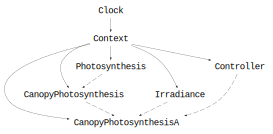

In [17]:
Cropbox.hierarchy(CanopyPhotosynthesisA)

`CanopyPhotosynthesisN` is an intermediate mix-in providing a common ground for Gauss and Euler version of the model. Instead of directly computing `Ag` for the whole canopy, it makes uses a `call` variable `A` for calculating a photosynthesis rate at a certain layer represented by a value of leaf area index (`L`). `A` will be later integrated over a total range of leaf area index from 0 to `L` for computing `Ag`.

- Eqn 5.15

$$
A(l) = \frac{\alpha I(l) \cdot A_{\mathrm{max}}}{\alpha I(l) + A_{\mathrm{max}}}
$$

- Table 5.1

| Symbol | Units | Description |
|:-------|:------|:------------|
| $A(l)$ | $$\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Leaf gross $\mathrm{CO_2}$ assimilation rate ($A_g$) of a leaf inside the canopy at depth $l$ |

In [18]:
@system CanopyPhotosynthesisN(CanopyPhotosynthesis, Irradiance, Controller) begin
    A(α, Amax, I; l) => begin
        Il = I(l)
        #= .. =#
    end ~ call(u"μmol/m^2/s")
end

CanopyPhotosynthesisN

#### Gaussian integration

`CanopyPhotosynthesisG` uses Gaussian integration method to compute `Ag` from `A` defined above. Let's use QuadGK for convenience.

In [19]:
@system CanopyPhotosynthesisG(CanopyPhotosynthesisN, Controller) begin
    Ag(A, L): gross_photosynthesis => begin
        #Cropbox.QuadGK.quadgk(A, 0, L) |> first
        X, W = Cropbox.QuadGK.gauss(3, 0, L)
        sum(W .* A.(X))
    end ~ track(u"μmol/m^2/s")
end

CanopyPhotosynthesisG

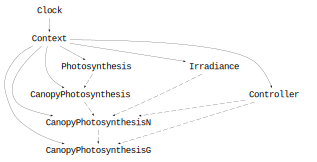

In [20]:
Cropbox.hierarchy(CanopyPhotosynthesisG)

#### Rectangular integration (Eulerian)

`CanopyPhotosynthesisE` uses Euler integration method to compute `Ag`. Overall structure is close to `CanopyPhotosynthesisG` except that it uses a parameter `dl` to control the size of integration step.

In [21]:
@system CanopyPhotosynthesisE(CanopyPhotosynthesisN, Controller) begin
    dl => 1.0 ~ preserve(parameter)
    Ag(A, L, dl): gross_photosynthesis => begin
        sum([A(l) * dl for l in dl:dl:L])
    end ~ track(u"μmol/m^2/s")
end

CanopyPhotosynthesisE

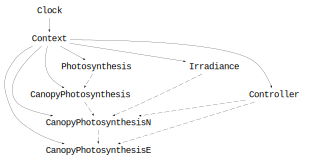

In [22]:
Cropbox.hierarchy(CanopyPhotosynthesisE)

Now it's time to make a plot of three models using the same option. We want to plot gross photosynthesis (`Ag`) against a range of leaf area index (`L`) from 0 to 15. `visualize()` function again conveniently provides a feature to draw a series of simulation lines from multiple systems.

Reproduce the results for three methods and compare them with the values from Gourdriaan and van Laar (1994) p. 181. Their analytical solution was 843.74 $\mathrm{\mu g}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ and Gaussian solution was 844.22 $\mathrm{\mu g}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ respectively. Note that 1 $\mathrm{\mu mol_{CO_2}}$ equals to 44 $\mathrm{\mu g_{CO_2}}$.

In [23]:
co2_molar_mass = 44u"μg" / 1u"μmol"

44.0 μg μmol^-1

In [24]:
instance(CanopyPhotosynthesisA).Ag' * co2_molar_mass

843.6887399642918 μg m^-2 s^-1

In [25]:
instance(CanopyPhotosynthesisG).Ag' * co2_molar_mass

844.1622218341407 μg m^-2 s^-1

In [26]:
instance(CanopyPhotosynthesisE).Ag' * co2_molar_mass

618.277857115745 μg m^-2 s^-1

Let's try a smaller integration step for the rectangular method. $dl$ is now decreased to 0.1 from 1.0 above.

In [27]:
instance(CanopyPhotosynthesisE, config = :0 => :dl => 0.1).Ag' * co2_molar_mass

819.7431487919014 μg m^-2 s^-1

In [28]:
models = [CanopyPhotosynthesisA, CanopyPhotosynthesisG, CanopyPhotosynthesisE]
xstep = :0 => :L => 0:0.1:10
names = ["Analytic", "Gauss", "Euler"]
kind = :scatter
ylim = (0, 30);

Note that the line of Gauss model (yellow) is barely visible since it's mostly overlapped with the line of analytic solution (blue).

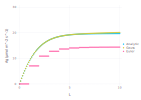

In [29]:
visualize(models, :L, :Ag; xstep, names, kind, ylim)

Plotting net photosynthesis (`An`) which takes out 10% of gross respiration (`Ag`) as dark respiration (`Rd`) can be easily done in a similar way.

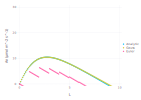

In [30]:
visualize(models, :L, :An; xstep, names, kind, ylim)

Note that Cropbox also implements a special kind of variable named `integrate` to cover the need of numerical integration as we explored in this notebook. Instead of relying on two separate variables, one `call` defining a function to be integrated and another `track` manually doing numerical integration, `integrate` can describe the same logic using a single variable. It takes a similar form as `call` putting the name of internal variable to be integrated (`l` in this case) after semi-colon (`;`) in the argument list. Then the range of integration is specified by `from` and `to` tags defined inside the parenthesis following the state name (`integrate`). As we want to integrate from 0 to `L` and the default value of `from` and `to` are 0, we only need to specify `to` as `L`. As a bonus, unit conversion would be automatically handled if any of these variables were assigned some units. `CanopyPhotosynthesisG2` implemented with `call` should behave in the exactly same way as `CanopyPhotosynthesisG` implemented earlier with `call` and `track`.

In [31]:
@system CanopyPhotosynthesisG2(CanopyPhotosynthesis, Irradiance, Controller) begin
    Ag(α, Amax, I; l): gross_photosynthesis => begin
        Il = I(l)
        α*Il * Amax / (α*Il + Amax)
    end ~ integrate(to = L, u"μmol/m^2/s")
end

CanopyPhotosynthesisG2

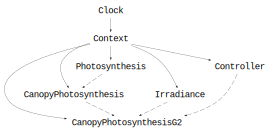

In [32]:
Cropbox.hierarchy(CanopyPhotosynthesisG2)

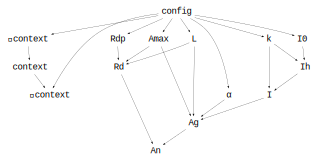

In [33]:
Cropbox.dependency(CanopyPhotosynthesisG2)

In [34]:
instance(CanopyPhotosynthesisG2)

context,,=,<Context>
config,,=,<Config>
α,(photochemical_efficiency),=,0.0494
Amax,(maximum_photosynthetic_rate),=,22.73 μmol m^-2 s^-1
Rd,(dark_respiration),=,11.365 μmol m^-2 s^-1
Ag,(gross_photosynthesis),=,19.1747 μmol m^-2 s^-1
An,(net_photosynthesis),=,7.80974 μmol m^-2 s^-1
L,(leaf_area_index),=,5.0
Rdp,(dark_respiration_ratio),=,0.1
I0,(irradiance_top),=,575.0 μmol m^-2 s^-1
k,(extinction_coeff),=,0.8


#### Sensitivity of Parameters

We can test sensitivty of parameters as we did earlier.

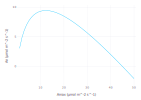

In [35]:
visualize(CanopyPhotosynthesisG2, :Amax, :An;
    xstep = :0 => :Amax => 1:50,
    kind = :line,
)

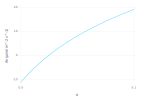

In [36]:
visualize(CanopyPhotosynthesisG2, :α, :An;
    xstep = :0 => :α => 0:0.001:0.1,
    xlim = (0, 0.1),
    kind = :line,
)

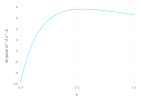

In [37]:
visualize(CanopyPhotosynthesisG2, :k, :An;
    xstep = :0 => :k => 0:0.01:1,
    kind = :line,
)

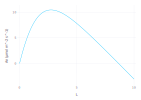

In [38]:
visualize(CanopyPhotosynthesisG2, :L, :An;
    xstep = :0 => :L => 0:0.1:10,
    kind = :line,
)

#### Light response of leaf and canopy photosynthesis

In [ ]:
@system PhotosynthesisRH(Photosynthesis, Controller) begin
    I: irradiance => 0 ~ preserve(parameter, u"μmol/m^2/s")

    Ag(I, α, Amax): gross_photosynthesis => begin
        (α*I*Amax)/(α*I+Amax)
    end ~ track(u"μmol/m^2/s")
end

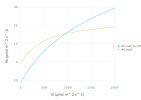

In [39]:
p = visualize(CanopyPhotosynthesisG2, :I0, :An;
    config = :0 => :L => 5,
    xstep = :0 => :I0 => 0:10:2000,
    kind = :line,
    name = "An,can (L=5)",
)
visualize!(p, PhotosynthesisRH, :I, :An;
    xstep = :0 => :I => 0:10:2000,
    kind = :line,
    name = "An,leaf",
)

We can make an interactive plot using `manipulate()` function.

In [40]:
manipulate(CanopyPhotosynthesisG2, :I0, :An;
    parameters = :0 => :L => 0:0.1:10,
    xstep = :0 => :I0 => 0:10:2000,
    ylim = (-10, 30),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["L"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x0000ffff31779370, Task (runnable) @0x0000ffff31779370), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 1, 430418489509)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified

In [41]:
manipulate(parameters = :0 => :L => 0:0.1:10) do c
    p = visualize(CanopyPhotosynthesisG2, :I0, :An;
        config = c,
        xstep = :0 => :I0 => 0:10:2000,
        ylim = (-10, 30),
        kind = :line,
        name = "An,can",
    )
    visualize!(p, PhotosynthesisRH, :I, :An;
        xstep = :0 => :I => 0:10:2000,
        kind = :line,
        name = "An,leaf",
    )
end

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["L"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x0000ffff316628c0, Task (runnable) @0x0000ffff316628c0), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 281472788002192, 281472242696368)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    v